In [1]:
import requests

# Your API key (KEEP PRIVATE in real code)
API_KEY = "xUjLwHtt9dLpcH6FDyc9shcx28LZ967UUgLgtBzj"

# API Endpoint for Himawari NSRDB
url = "https://developer.nrel.gov/api/nsrdb/v2/solar/himawari-download.csv"

# Parameters
params = {
    "api_key": API_KEY,
    "email": "saiyedfaiez@gmail.com",
    "wkt": "POINT(77.4126 23.2599)",  # Replace with your actual lat/lon: (longitude latitude)
    "names": "2019",
    "leap_day": "false",
    "interval": "10",
    "utc": "false",
    "full_name": "Saiyed Faiez",       # Optional
    "affiliation": "IIT Indore",       # Optional
    "reason": "Solar forecasting project",  # Optional
    "mailing_list": "false"
}

# Request the data
response = requests.get(url, params=params)

# Save response if it's a CSV file
with open("himawari_2019_data.csv", "wb") as f:
    f.write(response.content)

print("Download complete: himawari_2019_data.csv")



Download complete: himawari_2019_data.csv


In [3]:
import pandas as pd

df = pd.read_csv("himawari_2019_data.csv", skiprows=2)  # skip header metadata
print(df.head())
print(df.columns)


   Year  Month  Day  Hour  Minute  Temperature  Alpha  Aerosol Optical Depth  \
0  2019      1    1     0       0         11.4   1.43                 0.7371   
1  2019      1    1     0      10         11.4   1.43                 0.7371   
2  2019      1    1     0      20         11.3   1.43                 0.7371   
3  2019      1    1     0      30         11.3   1.43                 0.7371   
4  2019      1    1     0      40         11.3   1.41                 0.7507   

   Asymmetry  Clearsky DHI  ...  Fill Flag  GHI  Ozone  Relative Humidity  \
0       0.62             0  ...          0    0  0.272              99.56   
1       0.62             0  ...          0    0  0.272              99.56   
2       0.62             0  ...          0    0  0.272             100.00   
3       0.62             0  ...          0    0  0.273             100.00   
4       0.62             0  ...          0    0  0.273              99.78   

   Solar Zenith Angle  Surface Albedo  Pressure  Precipi

In [5]:
!pip install requests prophet pvlib pandas matplotlib scikit-learn


     ---------------------------------------- 0.0/46.6 kB ? eta -:--:--
     ----------------- ---------------------- 20.5/46.6 kB ? eta -:--:--
     ----------------- ---------------------- 20.5/46.6 kB ? eta -:--:--
     ----------------- ---------------------- 20.5/46.6 kB ? eta -:--:--
     --------------------------------- ---- 41.0/46.6 kB 163.4 kB/s eta 0:00:01
     -------------------------------------- 46.6/46.6 kB 166.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB ? eta -:--:--
    --------------------------------------- 0.2/13.3 MB 876.1 kB/s eta 0:00:16
    --------------------------------------- 0.2/13.3 MB 876.1 kB/s eta 0:00:16
    -------------------------------------

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Alpha',
       'Aerosol Optical Depth', 'Asymmetry', 'Clearsky DHI', 'Clearsky DNI',
       'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI', 'Fill Flag',
       'GHI', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed'],
      dtype='object')


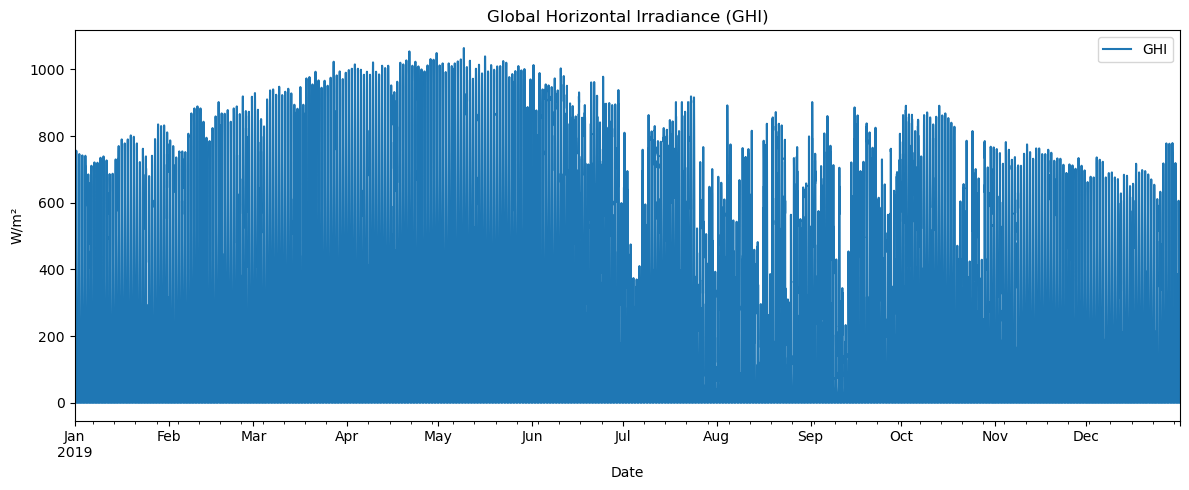

In [14]:
import pandas as pd

# load the CSV with the usual skiprows
df = pd.read_csv("himawari_2019_data.csv", skiprows=2)

# check the first few columns
print(df.columns)

# reconstruct datetime column
df['Timestamp'] = pd.to_datetime(dict(
    year=df['Year'],
    month=df['Month'],
    day=df['Day'],
    hour=df['Hour'],
    minute=df['Minute']
))

df.set_index('Timestamp', inplace=True)

# now you can safely plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
df['GHI'].plot(label='GHI')
plt.title("Global Horizontal Irradiance (GHI)")
plt.ylabel("W/m²")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()



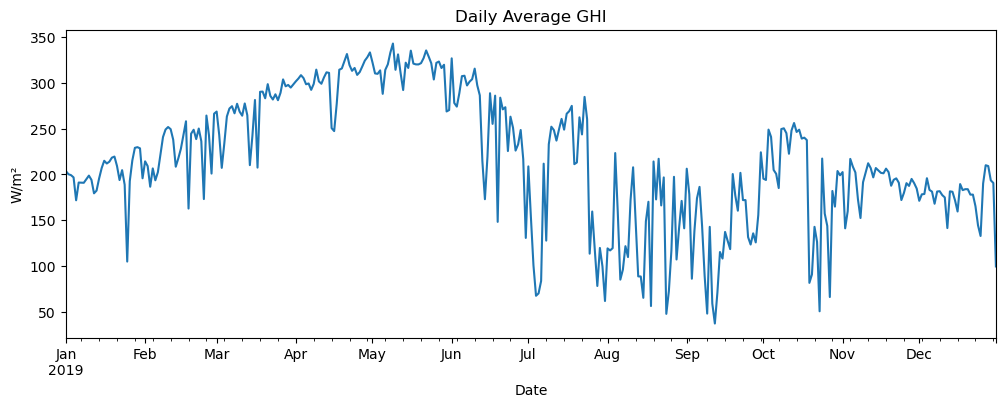

In [16]:
# Daily GHI average
df['GHI'].resample('D').mean().plot(figsize=(12, 4), title='Daily Average GHI')
plt.ylabel('W/m²')
plt.xlabel('Date')
plt.show()


19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:17 - cmdstanpy - INFO - Chain [1] done processing


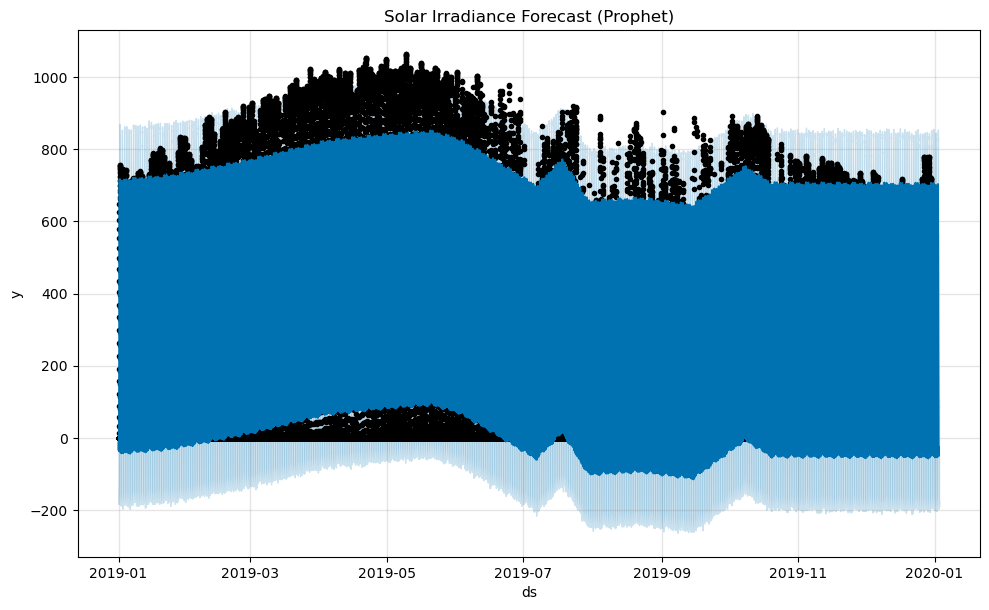

In [18]:
from prophet import Prophet

# Prophet expects columns 'ds' and 'y'
df_prophet = df.reset_index()[['Timestamp', 'GHI']].rename(columns={'Timestamp': 'ds', 'GHI': 'y'})

model = Prophet()
model.fit(df_prophet)

# Predict next 2 days (288 intervals if 10-min data)
future = model.make_future_dataframe(periods=288, freq='10min')
forecast = model.predict(future)

# Plot results
model.plot(forecast)
plt.title("Solar Irradiance Forecast (Prophet)")
plt.show()


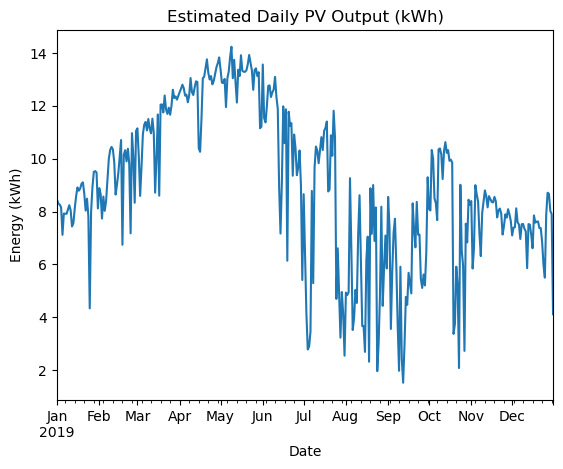

In [20]:
# Basic PV model: P = GHI * area * efficiency
panel_area = 1.6  # m² (per panel)
efficiency = 0.18  # 18%
df['PV_output_estimate'] = df['GHI'] * panel_area * efficiency / 1000  # in kW

df['PV_output_estimate'].resample('D').sum().plot(title='Estimated Daily PV Output (kWh)')
plt.ylabel("Energy (kWh)")
plt.xlabel("Date")
plt.show()


<Axes: title={'center': 'Estimated Daily PV Output (kWh)'}, xlabel='Timestamp'>

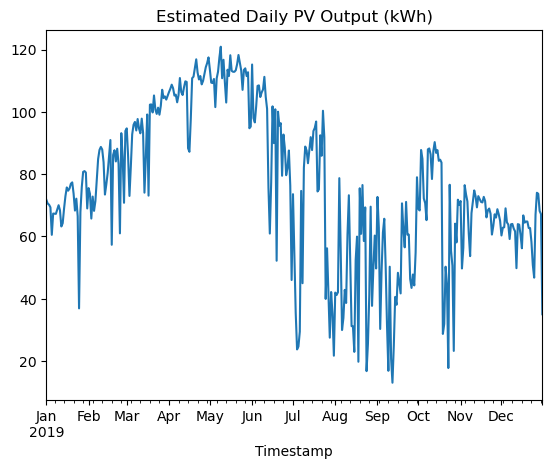

In [26]:
# System specifications
panel_area = 1.6     # m² per panel
panel_efficiency = 0.18  # 18% efficiency
num_panels = 10
derating_factor = 0.85   # accounts for wiring, inverter loss, etc.
# computing theoritical Instantaneous power (in kW)
df['PV_output_kw'] = (
    df['GHI'] * panel_area * num_panels * panel_efficiency * derating_factor
) / 1000  # convert W to kW

# Daily energy (in kWh)
daily_energy = df['PV_output_kw'].resample('D').sum()
daily_energy.plot(title="Estimated Daily PV Output (kWh)")


In [28]:
# temperature derating 

# Estimate cell temperature
df['T_cell'] = df['Temperature'] + (df['GHI'] / 800) * 20

# Temperature coefficient
beta = 0.004  # 0.4% per °C drop

# Adjust efficiency
df['eff_temp'] = panel_efficiency * (1 - beta * (df['T_cell'] - 25))

# Compute power with temperature-adjusted efficiency
df['PV_output_kw_temp'] = (
    df['GHI'] * panel_area * num_panels * df['eff_temp'] * derating_factor
) / 1000


In [5]:
pip install streamlit


In [7]:
import streamlit as st
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

st.title("🔆 Solar PV Forecasting Dashboard")

uploaded_file = st.file_uploader("Upload your NREL GHI CSV file", type=["csv"])
if uploaded_file:
    df = pd.read_csv(uploaded_file, parse_dates=["Time"], index_col="Time")
    
    st.subheader("📊 Raw Data")
    st.line_chart(df["GHI"])

    st.subheader("⚙️ Physics-Based PV Model")
    # Simple calculation
    area = st.number_input("PV Area (m²)", value=10.0)
    eff = st.slider("Efficiency (%)", 0, 100, 15)
    derate = st.slider("Derating Factor", 0.0, 1.0, 0.77)

    df["PV_output"] = df["GHI"] * area * (eff / 100) * derate / 1000

    st.line_chart(df["PV_output"])

    st.subheader("📈 Forecast using Prophet")

    df_prophet = df[["PV_output"]].reset_index().rename(columns={"Time": "ds", "PV_output": "y"})
    model = Prophet()
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=48, freq="H")
    forecast = model.predict(future)

    st.line_chart(forecast.set_index("ds")[["yhat"]])

    st.success("✅ Forecasting Complete!")


2025-08-06 22:48:19.033 
  command:

    streamlit run C:\Users\saiye\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [15]:

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

st.set_page_config(page_title="Solar PV Forecasting", layout="centered")
st.title("🔆 Solar PV Forecasting Dashboard")

st.markdown("""
Upload your **satellite solar data** (CSV with at least `Time` and `GHI` columns). 
This app will:
- Run a physics-based PV model
- Forecast future PV output using Prophet
- Visualize actual vs predicted output
""")

uploaded_file = st.file_uploader("📁 Upload your NREL CSV file", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')
    
    st.subheader("📊 Raw GHI Data")
    st.line_chart(df['GHI'])

    st.subheader("⚙️ PV Power Model")
    area = st.number_input("PV Area (m²)", value=10.0)
    efficiency = st.slider("Efficiency (%)", min_value=1, max_value=30, value=15)
    derating = st.slider("Derating Factor", min_value=0.1, max_value=1.0, value=0.77)

    df['PV_output'] = df['GHI'] * area * (efficiency / 100) * derating / 1000

    st.line_chart(df['PV_output'])

    st.subheader("📈 Forecast with Prophet")
    df_prophet = df[['PV_output']].reset_index().rename(columns={'Time': 'ds', 'PV_output': 'y'})

    m = Prophet()
    m.fit(df_prophet)

    future = m.make_future_dataframe(periods=48, freq='H')
    forecast = m.predict(future)

    fig, ax = plt.subplots(figsize=(10, 4))
    m.plot(forecast, ax=ax)
    st.pyplot(fig)

    st.success("✅ Forecast complete!")
    st.download_button("Download Forecast CSV", forecast.to_csv(index=False), file_name="forecast.csv")
else:
    st.info("Upload a file to get started.")

